In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import sqlite3
import folium
from folium import plugins
from IPython.display import IFrame
from shapely.geometry import Point, LineString
from folium import plugins
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import community
from IPython.display import display

In [2]:
bus_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_bus.csv', sep=',', dtype=object)
combined_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_combined.csv')
ferry_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_ferry.csv')
temporal_day_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_temporal_day.csv')
temporal_week_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_temporal_week.csv')
walk_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_walk.csv')
nodes_network = pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/network_nodes.csv')

stops = gpd.read_file('/lustrehome/niloofar/niloofar_work/ENEA/venice/stops.geojson')
sections = gpd.read_file('/lustrehome/niloofar/niloofar_work/ENEA/venice/sections.geojson')
routes = gpd.read_file('/lustrehome/niloofar/niloofar_work/ENEA/venice/routes.geojson')
top=pd.read_excel('/lustrehome/niloofar/niloofar_work/ENEA/venice/Topvenice.xlsx')
venice_final=pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/okvenice.csv')

In [3]:
from shapely.wkt import loads

# Assuming venice_final is your DataFrame
venice_final['lon_bus'] = venice_final['geometry_bus_tram'].apply(lambda x: loads(x).xy[0][0] if 'LINESTRING' in x else None)
venice_final['lat_bus'] = venice_final['geometry_bus_tram'].apply(lambda x: loads(x).xy[1][0] if 'LINESTRING' in x else None)
venice_final['lon_tram'] = venice_final['geometry_bus_tram'].apply(lambda x: loads(x).xy[0][1] if 'LINESTRING' in x else None)
venice_final['lat_tram'] = venice_final['geometry_bus_tram'].apply(lambda x: loads(x).xy[1][1] if 'LINESTRING' in x else None)

# Drop the original 'geometry_bus_tram' column if it exists
venice_final = venice_final.drop('geometry_bus_tram', axis=1, errors='ignore')

In [4]:
# Assuming venice_final is your DataFrame
venice_final['stop_lon'] = venice_final['geometry_stops'].apply(lambda x: loads(x).xy[0][0] if 'POINT' in x else None)
venice_final['stop_lat'] = venice_final['geometry_stops'].apply(lambda x: loads(x).xy[1][0] if 'POINT' in x else None)

# Drop the original 'geometry_stops' column
venice_final = venice_final.drop('geometry_stops', axis=1)

In [5]:
# Rename lat_tram to lat_ferry and lon_tram to lon_ferry
venice_final = venice_final.rename(columns={'lat_tram': 'lat_ferry', 'lon_tram': 'lon_ferry'})

# Now, your DataFrame has columns lat_ferry and lon_ferry

In [6]:
# Assuming venice_original is the original DataFrame
venice_final = venice_final  # Assign the modified DataFrame to the original variable
# Save the modified DataFrame to the original file (replace 'original_file.csv' with your actual file path)
venice_final.to_csv('okvenice.csv', index=False)
venice_final=pd.read_csv('/lustrehome/niloofar/niloofar_work/ENEA/venice/okvenice.csv')

In [17]:
import folium
import networkx as nx
import pandas as pd
# Filter only bus routes
bus_df_venice = venice_final[venice_final['BUS'] == 1]
# Create a directed graph using networkx
G_venice = nx.DiGraph()
# Add nodes to the graph
for index, row in bus_df_venice.iterrows():
    node_id = row['id']
    stop_name = row['name']
    G_venice.add_node(node_id, name=stop_name)

# Create a Folium map centered around Venice
venice_map = folium.Map(location=[45.4408, 12.3155], zoom_start=13)

# Add nodes to the map
for node_id, data in G_venice.nodes(data=True):
    stop_name = data.get('name', '')
    
    # Extract coordinates from 'lon_bus' and 'lat_bus' columns for buses
    stop_data = bus_df_venice[bus_df_venice['id'] == node_id][['lon_bus', 'lat_bus']].values
    
    if len(stop_data) > 0:
        lon, lat = stop_data[0]
        
        folium.Marker(
            location=[lat, lon],
            popup=stop_name,
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(venice_map)

# Add edges to the graph
for index, row in bus_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_venice.add_edge(from_stop, to_stop)

# Add edges to the map as PolyLines
for edge in G_venice.edges():
    from_stop, to_stop = edge
    
    # Extract coordinates for 'lon_bus' and 'lat_bus' columns for buses
    from_coords = bus_df_venice.loc[bus_df_venice['id'] == from_stop, ['lon_bus', 'lat_bus']].values
    to_coords = bus_df_venice.loc[bus_df_venice['id'] == to_stop, ['lon_bus', 'lat_bus']].values
    
    if len(from_coords) > 0 and len(to_coords) > 0:
        from_lon, from_lat = from_coords[0]
        to_lon, to_lat = to_coords[0]
        
        # Add PolyLine to the map
        folium.PolyLine(locations=[[from_lat, from_lon], [to_lat, to_lon]], color='blue', weight=2, opacity=0.7).add_to(venice_map)
# Display the map
venice_map

In [25]:
import networkx as nx
import pandas as pd
# Filter only bus routes
bus_df_venice = venice_final[venice_final['BUS'] == 1]

G_venice = nx.DiGraph()

# Add nodes and edges to the graph
for index, row in bus_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_venice.add_edge(from_stop, to_stop)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G_venice)

# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G_venice)

# Calculate eigenvector centrality with increased max_iter
eigenvector_centrality = nx.eigenvector_centrality(G_venice, max_iter=1000)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G_venice)

# Create dataframes for top 10 nodes for each centrality measure with additional information
def create_dataframe(centrality_measure):
    nodes_info = [{'id': node, 'name': bus_df_venice.loc[bus_df_venice['id'] == node, 'name'].values[0],
                   'lat': bus_df_venice.loc[bus_df_venice['id'] == node, 'lat_bus'].values[0],
                   'lon': bus_df_venice.loc[bus_df_venice['id'] == node, 'lon_bus'].values[0]}
                  for node in centrality_measure if node in bus_df_venice['id'].values][:10]
    return pd.DataFrame(nodes_info)

# Create dataframes for each centrality measure
df_degree = create_dataframe(degree_centrality)
df_closeness = create_dataframe(closeness_centrality)
df_eigenvector = create_dataframe(eigenvector_centrality)
df_betweenness = create_dataframe(betweenness_centrality)

# Display the dataframes
print("Top 10 nodes by degree centrality:")
print(df_degree)

print("\nTop 10 nodes by closeness centrality:")
print(df_closeness)

print("\nTop 10 nodes by eigenvector centrality:")
print(df_eigenvector)

print("\nTop 10 nodes by betweenness centrality:")
print(df_betweenness)

Top 10 nodes by degree centrality:
     id                      name        lat        lon
0   135    Incr. Ponte per Marano  45.457417  12.118905
1   426        Incr. via Giuliani  45.496338  12.240108
2   136               SFMR Spinea  45.490921  12.176497
3   429                Civico 249  45.502048  12.324718
4   137  Mazzocco Chiesa Piazzale  45.552647  12.267636
5  1622                    Scuole  45.394653  12.065623
6   138             Marano Centro  45.465061  12.117574
7   715                  Cimitero  45.481056  12.161246
8   140  Civico 102  Marano Ponte  45.465130  12.118348
9   139             Marano Centro  45.465305  12.117216

Top 10 nodes by closeness centrality:
     id                      name        lat        lon
0   135    Incr. Ponte per Marano  45.457417  12.118905
1   426        Incr. via Giuliani  45.496338  12.240108
2   136               SFMR Spinea  45.490921  12.176497
3   429                Civico 249  45.502048  12.324718
4   137  Mazzocco Chiesa Piazz

In [68]:
#edge betweenness centrality
#equation 21 
edge_betweenness_centrality = nx.edge_betweenness_centrality(G_venice)

# Create dataframes for top 10 edges for edge betweenness centrality with additional information
def create_edge_dataframe(centrality_measure):
    edges_info = [{'from_stop': edge[0], 'to_stop': edge[1],
                   'betweenness_centrality': centrality_measure[edge]}
                  for edge in sorted(centrality_measure, key=centrality_measure.get, reverse=True)[:10]]
    return pd.DataFrame(edges_info)

# Create dataframe for edge betweenness centrality
df_edge_betweenness = create_edge_dataframe(edge_betweenness_centrality)

# Display the dataframe
print("\nTop 10 edges by betweenness centrality:")
print(df_edge_betweenness)



Top 10 edges by betweenness centrality:
   from_stop  to_stop  betweenness_centrality
0        324      540                0.081619
1        470     1300                0.065241
2       1804     1809                0.058632
3        835      834                0.057778
4        834      829                0.057544
5        809      863                0.056889
6       1784     1792                0.055889
7        551     1786                0.055318
8        811      552                0.054862
9       1248     1246                0.053879


In [70]:
#equation13 

# Calculate the shortest paths between all pairs of nodes
shortest_paths = dict(nx.all_pairs_shortest_path_length(G_venice))

# Calculate efficiency
N = len(G_venice.nodes)
efficiency_sum = 0

for i in G_venice.nodes:
    for j in G_venice.nodes:
        if i != j and j in shortest_paths[i]:
            dij = shortest_paths[i][j]
            efficiency_sum += 1 / dij

# Calculate efficiency
efficiency = efficiency_sum / (N * (N - 1))

print("Efficiency of the network:", efficiency)

Efficiency of the network: 0.024957029162748456


In [99]:
def geodesic_vulnerability(G, v):
    # Calculate the shortest paths for all nodes
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Calculate the shortest paths when bus v is failed
    failed_shortest_paths = dict(nx.single_source_shortest_path_length(G, v))
    
    # Calculate the numerator and denominator for geodesic vulnerability
    numerator_sum = 0
    denominator_sum = 0
    
    for i in G.nodes:
        for j in G.nodes:
            if i != j and j in all_shortest_paths[i]:
                dij = all_shortest_paths[i][j]
                
                # Check if the path exists in failed_shortest_paths
                dvij = failed_shortest_paths[j] if j in failed_shortest_paths else float('inf')
                
                # Check for both infinity and zero distances
                if dij != 0 and dvij != 0 and dvij != float('inf'):
                    numerator_sum += 1 / dvij
                    denominator_sum += 1 / dij
    
    # Calculate geodesic vulnerability and normalize to [0, 1]
    geodesic_vulnerability = max(1 - (numerator_sum / denominator_sum), 0)
    
    print(f"Numerator Sum: {numerator_sum}")
    print(f"Denominator Sum: {denominator_sum}")
    print(f"Geodesic Vulnerability: {geodesic_vulnerability}")
    
    return geodesic_vulnerability

# Example: Calculate geodesic vulnerability for bus 'v' (replace 'your_bus_id' with the actual bus ID)
your_bus_id = 135
if your_bus_id in G_venice.nodes:
    bus_vulnerability = geodesic_vulnerability(G_venice, your_bus_id)
    print(f"Geodesic vulnerability for bus {your_bus_id}: {bus_vulnerability}")
else:
    print(f"Bus {your_bus_id} not found in the graph.")


Numerator Sum: 110876.18533718293
Denominator Sum: 111887.5198278629
Geodesic Vulnerability: 0.009038849839873908
Geodesic vulnerability for bus 135: 0.009038849839873908


In [116]:
venice_bus_df = venice_final[venice_final['BUS'] == 1]
G_venice_bus = nx.DiGraph()
# Add nodes and edges to the graph for bus
for index, row in venice_bus_df.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_venice_bus.add_edge(from_stop, to_stop)
# Function to calculate geodesic vulnerability for each node
def geodesic_vulnerability(G, v):
    # Calculate the shortest paths for all nodes
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Calculate the shortest paths when node v is failed
    failed_shortest_paths = dict(nx.single_source_shortest_path_length(G, v))
    # Calculate the numerator and denominator for geodesic vulnerability
    numerator_sum = 0
    denominator_sum = 0
    
    for i in G.nodes:
        for j in G.nodes:
            if i != j and j in all_shortest_paths[i]:
                dij = all_shortest_paths[i][j]
                
                # Check if the path exists in failed_shortest_paths
                dvij = failed_shortest_paths[j] if j in failed_shortest_paths else float('inf')
                
                # Check for both infinity and zero distances
                if dij != 0 and dvij != 0 and dvij != float('inf'):
                    numerator_sum += 1 / dvij
                    denominator_sum += 1 / dij
    
    # Check if denominator_sum is zero before performing the division
    if denominator_sum == 0:
        return 0
    
    # Calculate geodesic vulnerability and normalize to [0, 1]
    geodesic_vulnerability = max(1 - (numerator_sum / denominator_sum), 0)
    
    return geodesic_vulnerability
# Calculate geodesic vulnerability for each node in the bus network
venice_bus_vulnerabilities = {}
for node in G_venice_bus.nodes:
    vulnerability = geodesic_vulnerability(G_venice_bus, node)
    venice_bus_vulnerabilities[node] = vulnerability
# Create DataFrame for bus station vulnerabilities with additional information
df_venice_bus_station_vulnerabilities = pd.DataFrame(list(venice_bus_vulnerabilities.items()), columns=['id', 'Geodesic_Vulnerability'])
df_venice_bus_station_vulnerabilities = pd.merge(df_venice_bus_station_vulnerabilities, venice_bus_df[['stop_I', 'name', 'lat_bus', 'lon_bus']], left_on='id', right_on='stop_I', how='left')
df_venice_bus_station_vulnerabilities = df_venice_bus_station_vulnerabilities[['id', 'name', 'lat_bus', 'lon_bus', 'Geodesic_Vulnerability']]
# Display the top 10 nodes by geodesic vulnerability with additional information
top_nodes_venice_bus = df_venice_bus_station_vulnerabilities.nlargest(10, 'Geodesic_Vulnerability')
print("Top 10 bus stations in Venice by geodesic vulnerability:")
print(top_nodes_venice_bus)

Top 10 bus stations in Venice by geodesic vulnerability:
       id                   name    lat_bus    lon_bus  Geodesic_Vulnerability
1108  870        Hotel  Magnolia  45.612492  12.237393                0.546751
1263  871   Tratt. "All' Albera"  45.617046  12.238400                0.538854
1264  872  Localita' Alle Grazie  45.620777  12.239066                0.530617
1261  869        bivio S.Trovaso  45.625881  12.239435                0.522014
1262  873                Goppion  45.630810  12.239921                0.513021
1260  868           Incr. Dosson  45.633881  12.240264                0.503606
1336  924       Incr. via Matter  45.592056  12.333408                0.500508
1259  867  Frescada (v.2 Giugno)  45.641190  12.241307                0.493737
1333  922            Rist. Odino  45.584175  12.352501                0.490406
1258  866  Civico 13  - Frescada  45.644306  12.241645                0.483375


In [48]:
import folium
nodes_data = [
    (135, "Incr. Ponte per Marano", 45.457417, 12.118905),
    (426, "Incr. via Giuliani", 45.496338, 12.240108),
    (136, "SFMR Spinea", 45.490921, 12.176497),
    (429, "Civico 249", 45.502048, 12.324718),
    (137, "Mazzocco Chiesa Piazzale", 45.552647, 12.267636),
    (1622, "Scuole", 45.394653, 12.065623),
    (138, "Marano Centro", 45.465061, 12.117574),
    (715, "Cimitero", 45.481056, 12.161246),
    (140, "Civico 102  Marano Ponte", 45.465130, 12.118348),
    (139, "Marano Centro", 45.465305, 12.117216)
]
# Create a Folium map centered around Venice
venice_map_nodes = folium.Map(location=[45.4408, 12.3155], zoom_start=12)

# Function to add markers with pop-ups for nodes on the map
def add_marker(map_obj, lat, lon, popup_text, color):
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(map_obj)

# Add markers for provided nodes
for node_id, node_name, lat, lon in nodes_data:
    # Generate pop-up text with node information
    popup_text = f"ID: {node_id}<br>Name: {node_name}"
    
    # Add marker with different color based on node properties (you can customize this logic)
    # For example, using different colors for nodes with even and odd IDs
    color = 'green' if node_id % 2 == 0 else 'green'
    
    add_marker(venice_map_nodes, lat, lon, popup_text, color)
# Display the map
venice_map_nodes

In [3]:
import folium

# Provided nodes data
nodes_data = [
    (135, "Incr. Ponte per Marano", 45.457417, 12.118905),
    (426, "Incr. via Giuliani", 45.496338, 12.240108),
    (136, "SFMR Spinea", 45.490921, 12.176497),
    (429, "Civico 249", 45.502048, 12.324718),
    (137, "Mazzocco Chiesa Piazzale", 45.552647, 12.267636),
    (1622, "Scuole", 45.394653, 12.065623),
    (138, "Marano Centro", 45.465061, 12.117574),
    (715, "Cimitero", 45.481056, 12.161246),
    (140, "Civico 102  Marano Ponte", 45.465130, 12.118348),
    (139, "Marano Centro", 45.465305, 12.117216)
]

# Provided top 10 bus stations with geodesic vulnerability
bus_stations_data = [
    (870, "Hotel Magnolia", 45.612492, 12.237393, 0.546751),
    (871, "Tratt. 'All' Albera'", 45.617046, 12.238400, 0.538854),
    (872, "Localita' Alle Grazie", 45.620777, 12.239066, 0.530617),
    (869, "bivio S.Trovaso", 45.625881, 12.239435, 0.522014),
    (873, "Goppion", 45.630810, 12.239921, 0.513021),
    (868, "Incr. Dosson", 45.633881, 12.240264, 0.503606),
    (924, "Incr. via Matter", 45.592056, 12.333408, 0.500508),
    (867, "Frescada (v.2 Giugno)", 45.641190, 12.241307, 0.493737),
    (922, "Rist. Odino", 45.584175, 12.352501, 0.490406),
    (866, "Civico 13  - Frescada", 45.644306, 12.241645, 0.483375)
]

# Create a Folium map centered around Venice
venice_map = folium.Map(location=[45.4408, 12.3155], zoom_start=12)

# Function to add markers with pop-ups for nodes on the map
def add_marker(map_obj, lat, lon, popup_text, color):
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(map_obj)

# Add markers for provided nodes
for node_id, node_name, lat, lon in nodes_data:
    # Generate pop-up text with node information
    popup_text = f"ID: {node_id}<br>Name: {node_name}"
    
    # Add marker with different color based on node properties (you can customize this logic)
    # For example, using different colors for nodes with even and odd IDs
    color = 'green' if node_id % 2 == 0 else 'green'
    
    add_marker(venice_map, lat, lon, popup_text, color)

# Add markers for top 10 bus stations with different color based on geodesic vulnerability
for bus_id, bus_name, lat, lon, geodesic_vuln in bus_stations_data:
    # Generate pop-up text with bus station information and geodesic vulnerability
    popup_text = f"ID: {bus_id}<br>Name: {bus_name}<br>Geodesic Vulnerability: {geodesic_vuln:.4f}"
    
    # Add marker with different color based on geodesic vulnerability
    # You can customize this logic based on your preference
    color = 'blue' if geodesic_vuln > 0.5 else 'blue'
    
    add_marker(venice_map, lat, lon, popup_text, color)

# Display the map
venice_map


In [63]:
G_venice = nx.DiGraph()
# Add nodes to the graph
for index, row in bus_df_venice.iterrows():
    node_id = row['id']
    G_venice.add_node(node_id)

# Add edges to the graph
for index, row in bus_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_venice.add_edge(from_stop, to_stop)

# Calculate in-degree and out-degree for bus routes in Venice
in_degrees_venice = dict(G_venice.in_degree())
out_degrees_venice = dict(G_venice.out_degree())

# Get top 10 nodes by in-degree
top_10_in_degree_venice = sorted(in_degrees_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top 10 nodes by out-degree
top_10_out_degree_venice = sorted(out_degrees_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Print top 10 nodes by in-degree for Venice ferry routes
print("\nTop 10 Nodes by In-Degree for Venice bus Routes:")
if not top_10_in_degree_ferry_venice:
    print("No data for in-degree centrality.")
else:
    for node_id, in_degree in top_10_in_degree_ferry_venice:
        node_info = ferry_df_venice[ferry_df_venice['id'] == node_id][['id', 'name', 'lat_bus', 'lon_bus']].values[0]
        print(f"Node {node_info[0]} ({node_info[1]}): (Lat: {node_info[2]}, Lon: {node_info[3]})")

# Print top 10 nodes by out-degree for Venice ferry routes
print("\nTop 10 Nodes by Out-Degree for Venice bus Routes:")
if not top_10_out_degree_ferry_venice:
    print("No data for out-degree centrality.")
else:
    for node_id, out_degree in top_10_out_degree_ferry_venice:
        node_info = ferry_df_venice[ferry_df_venice['id'] == node_id][['id', 'name', 'lat_bus', 'lon_bus']].values[0]
        print(f"Node {node_info[0]} ({node_info[1]}):  (Lat: {node_info[2]}, Lon: {node_info[3]})")


Top 10 Nodes by In-Degree for Venice bus Routes:
Node 15 (Lido S. Nicolo' N\T): (Lat: 45.425873, Lon: 12.378331)
Node 75 (S. Marcuola-Casino' DX): (Lat: 45.442444, Lon: 12.32882)
Node 102 (Murano Museo DX): (Lat: 45.456104, Lon: 12.355435)
Node 2 (Guglie dx): (Lat: 45.444294, Lon: 12.32445)
Node 6 (Ferrovia "D"): (Lat: 45.440216, Lon: 12.321242)
Node 27 (Murano Museo SX): (Lat: 45.456139, Lon: 12.355189)
Node 64 (Giudecca Palanca SX): (Lat: 45.426849, Lon: 12.325638)
Node 73 (P.le Roma (S. Chiara) "G"): (Lat: 45.438816, Lon: 12.319038)
Node 103 (Murano Venier): (Lat: 45.457447, Lon: 12.351191)
Node 112 (Lido (S.M.E.) "B"): (Lat: 45.417992, Lon: 12.368725)

Top 10 Nodes by Out-Degree for Venice bus Routes:
Node 15 (Lido S. Nicolo' N\T):  (Lat: 45.425873, Lon: 12.378331)
Node 75 (S. Marcuola-Casino' DX):  (Lat: 45.442444, Lon: 12.32882)
Node 102 (Murano Museo DX):  (Lat: 45.456104, Lon: 12.355435)
Node 56 (S. Zaccaria (Jolanda) "D"):  (Lat: 45.433456, Lon: 12.342809)
Node 73 (P.le Roma 

In [60]:
import folium
# Define the center of the map (you can adjust this based on your data)
map_center = [45.438023, 12.303988]

# Create a Folium map
venice_map = folium.Map(location=map_center, zoom_start=13)
nodes_data_in_degree = [
    {"Node": 15, "Location": "Lido S. Nicolo' N\\T", "Lat": 45.425873, "Lon": 12.378331, "DegreeType": "In-Degree"},
    {"Node": 75, "Location": "S. Marcuola-Casino' DX", "Lat": 45.442444, "Lon": 12.32882, "DegreeType": "In-Degree"},
    {"Node": 102, "Location": "Murano Museo DX", "Lat": 45.456104, "Lon": 12.355435, "DegreeType": "In-Degree"},
    {"Node": 2, "Location": "Guglie dx", "Lat": 45.444294, "Lon": 12.32445, "DegreeType": "In-Degree"},
    {"Node": 6, "Location": "Ferrovia \"D\"", "Lat": 45.440216, "Lon": 12.321242, "DegreeType": "In-Degree"},
    {"Node": 27, "Location": "Murano Museo SX", "Lat": 45.456139, "Lon": 12.355189, "DegreeType": "In-Degree"},
    {"Node": 64, "Location": "Giudecca Palanca SX", "Lat": 45.426849, "Lon": 12.325638, "DegreeType": "In-Degree"},
    {"Node": 73, "Location": "P.le Roma (S. Chiara) \"G\"", "Lat": 45.438816, "Lon": 12.319038, "DegreeType": "In-Degree"},
    {"Node": 103, "Location": "Murano Venier", "Lat": 45.457447, "Lon": 12.351191, "DegreeType": "In-Degree"},
    {"Node": 112, "Location": "Lido (S.M.E.) \"B\"", "Lat": 45.417992, "Lon": 12.368725, "DegreeType": "In-Degree"},
]

nodes_data_out_degree = [
    {"Node": 15, "Location": "Lido S. Nicolo' N\\T", "Lat": 45.425873, "Lon": 12.378331, "DegreeType": "Out-Degree"},
    {"Node": 75, "Location": "S. Marcuola-Casino' DX", "Lat": 45.442444, "Lon": 12.32882, "DegreeType": "Out-Degree"},
    {"Node": 102, "Location": "Murano Museo DX", "Lat": 45.456104, "Lon": 12.355435, "DegreeType": "Out-Degree"},
    {"Node": 56, "Location": "S. Zaccaria (Jolanda) \"D\"", "Lat": 45.433456, "Lon": 12.342809, "DegreeType": "Out-Degree"},
    {"Node": 73, "Location": "P.le Roma (S. Chiara) \"G\"", "Lat": 45.438816, "Lon": 12.319038, "DegreeType": "Out-Degree"},
    {"Node": 18, "Location": "Alberoni Faro Rocchetta N", "Lat": 45.341526, "Lon": 12.308979, "DegreeType": "Out-Degree"},
    {"Node": 27, "Location": "Murano Museo SX", "Lat": 45.456139, "Lon": 12.355189, "DegreeType": "Out-Degree"},
    {"Node": 34, "Location": "Crea", "Lat": 45.445278, "Lon": 12.321106, "DegreeType": "Out-Degree"},
    {"Node": 71, "Location": "P.le Roma (Parisi) \"D\"", "Lat": 45.439556, "Lon": 12.318337, "DegreeType": "Out-Degree"},
    {"Node": 103, "Location": "Murano Venier", "Lat": 45.457447, "Lon": 12.351191, "DegreeType": "Out-Degree"},
]

# Function to add markers to the map
def add_marker(node):
    color = 'red' if node['DegreeType'] == 'In-Degree' else 'green'
    
    popup_content = f"Node {node['Node']} ({node['Location']}): {node['DegreeType']} (Lat: {node['Lat']}, Lon: {node['Lon']})"

    folium.Marker(
        location=[node['Lat'], node['Lon']],
        popup=popup_content,
        icon=folium.Icon(color=color)
    ).add_to(venice_map)

# Add markers for all nodes with in-degree
for node in nodes_data_in_degree:
    add_marker(node)

# Add markers for all nodes with out-degree
for node in nodes_data_out_degree:
    add_marker(node)

# Save or display the map
venice_map 

##Ferry

In [18]:
import folium
import networkx as nx
import pandas as pd
# Filter only ferry routes
ferry_df_venice = venice_final[venice_final['FERRY'] == 1]

# Create a directed graph using networkx
G_ferry_venice = nx.DiGraph()

# Add nodes to the graph
for index, row in ferry_df_venice.iterrows():
    node_id = row['id']
    stop_name = row['name']
    G_ferry_venice.add_node(node_id, name=stop_name)

# Create a Folium map centered around Venice
venice_map_ferry = folium.Map(location=[45.4408, 12.3155], zoom_start=13)

# Add nodes to the map
for node_id, data in G_ferry_venice.nodes(data=True):
    stop_name = data.get('name', '')
    
    # Extract coordinates from 'lon_ferry' and 'lat_ferry' columns for ferries
    stop_data = ferry_df_venice[ferry_df_venice['id'] == node_id][['lon_ferry', 'lat_ferry']].values
    
    if len(stop_data) > 0:
        lon, lat = stop_data[0]
        
        folium.Marker(
            location=[lat, lon],
            popup=stop_name,
            icon=folium.Icon(color='blue', icon='ship')
        ).add_to(venice_map_ferry)

# Add edges to the graph
for index, row in ferry_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_ferry_venice.add_edge(from_stop, to_stop)

# Add edges to the map as PolyLines
for edge in G_ferry_venice.edges():
    from_stop, to_stop = edge
    
    # Extract coordinates for 'lon_ferry' and 'lat_ferry' columns for ferries
    from_coords = ferry_df_venice.loc[ferry_df_venice['id'] == from_stop, ['lon_ferry', 'lat_ferry']].values
    to_coords = ferry_df_venice.loc[ferry_df_venice['id'] == to_stop, ['lon_ferry', 'lat_ferry']].values
    
    if len(from_coords) > 0 and len(to_coords) > 0:
        from_lon, from_lat = from_coords[0]
        to_lon, to_lat = to_coords[0]
        
        # Add PolyLine to the map
        folium.PolyLine(locations=[[from_lat, from_lon], [to_lat, to_lon]], color='green', weight=2, opacity=0.7).add_to(venice_map_ferry)

# Display the map
venice_map_ferry


In [27]:
# Filter only ferry routes
ferry_df_venice = venice_final[venice_final['FERRY'] == 1]

# Create a directed graph for ferry routes using networkx
G_ferry_venice = nx.DiGraph()

# Add nodes and edges for ferry routes to the graph
for index, row in ferry_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_ferry_venice.add_edge(from_stop, to_stop)

# Calculate degree centrality for ferry routes
degree_centrality_ferry = nx.degree_centrality(G_ferry_venice)

# Calculate closeness centrality for ferry routes
closeness_centrality_ferry = nx.closeness_centrality(G_ferry_venice)

# Calculate eigenvector centrality for ferry routes with increased max_iter
eigenvector_centrality_ferry = nx.eigenvector_centrality(G_ferry_venice, max_iter=1000)

# Calculate betweenness centrality for ferry routes
betweenness_centrality_ferry = nx.betweenness_centrality(G_ferry_venice)

# Create dataframes for top 10 nodes for each centrality measure for ferry routes with additional information
def create_dataframe_ferry(centrality_measure):
    nodes_info = [{'id': node, 'name': ferry_df_venice.loc[ferry_df_venice['id'] == node, 'name'].values[0],
                   'lat': ferry_df_venice.loc[ferry_df_venice['id'] == node, 'lat_ferry'].values[0],
                   'lon': ferry_df_venice.loc[ferry_df_venice['id'] == node, 'lon_ferry'].values[0]}
                  for node in centrality_measure if node in ferry_df_venice['id'].values][:10]
    return pd.DataFrame(nodes_info)

# Create dataframes for each centrality measure for ferry routes
df_degree_ferry = create_dataframe_ferry(degree_centrality_ferry)
df_closeness_ferry = create_dataframe_ferry(closeness_centrality_ferry)
df_eigenvector_ferry = create_dataframe_ferry(eigenvector_centrality_ferry)
df_betweenness_ferry = create_dataframe_ferry(betweenness_centrality_ferry)

# Display the dataframes for ferry routes
print("Top 10 nodes by degree centrality for ferry routes:")
print(df_degree_ferry)

print("\nTop 10 nodes by closeness centrality for ferry routes:")
print(df_closeness_ferry)

print("\nTop 10 nodes by eigenvector centrality for ferry routes:")
print(df_eigenvector_ferry)

print("\nTop 10 nodes by betweenness centrality for ferry routes:")
print(df_betweenness_ferry)


Top 10 nodes by degree centrality for ferry routes:
    id                       name        lat        lon
0    1                 S. Basilio  45.433571  12.311260
1   29                Giardini DX  45.433384  12.342215
2   77                  Ca' D'Oro  45.439453  12.335298
3    2                  Guglie dx  45.446289  12.319780
4   73  P.le Roma (S. Chiara) "G"  45.441383  12.309408
5   42                 Rialto "A"  45.439453  12.335298
6  102            Murano Museo DX  45.454693  12.356580
7    3              F.te Nove "A"  45.452663  12.354642
8   61                   Celestia  45.439205  12.357293
9   38            Sacca Fisola SX  45.433571  12.311260

Top 10 nodes by closeness centrality for ferry routes:
    id                       name        lat        lon
0    1                 S. Basilio  45.433571  12.311260
1   29                Giardini DX  45.433384  12.342215
2   77                  Ca' D'Oro  45.439453  12.335298
3    2                  Guglie dx  45.446289  12.319

In [47]:
import folium

# Top nodes by degree centrality
top_nodes_degree = [
    (1, "S. Basilio", 45.433571, 12.311260),
    (29, "Giardini DX", 45.433384, 12.342215),
    (77, "Ca' D'Oro", 45.439453, 12.335298),
    (2, "Guglie dx", 45.446289, 12.319780),
    (73, "P.le Roma (S. Chiara) 'G'", 45.441383, 12.309408),
    (42, "Rialto 'A'", 45.439453, 12.335298),
    (102, "Murano Museo DX", 45.454693, 12.356580),
    (3, "F.te Nove 'A'", 45.452663, 12.354642),
    (61, "Celestia", 45.439205, 12.357293),
    (38, "Sacca Fisola SX", 45.433571, 12.311260)
]

# Top nodes by closeness centrality
top_nodes_closeness = [
    (1, "S. Basilio", 45.433571, 12.311260),
    (29, "Giardini DX", 45.433384, 12.342215),
    (77, "Ca' D'Oro", 45.439453, 12.335298),
    (2, "Guglie dx", 45.446289, 12.319780),
    (73, "P.le Roma (S. Chiara) 'G'", 45.441383, 12.309408),
    (42, "Rialto 'A'", 45.439453, 12.335298),
    (102, "Murano Museo DX", 45.454693, 12.356580),
    (3, "F.te Nove 'A'", 45.452663, 12.354642),
    (61, "Celestia", 45.439205, 12.357293),
    (38, "Sacca Fisola SX", 45.433571, 12.311260)
]

# Top nodes by eigenvector centrality
top_nodes_eigenvector = [
    (1, "S. Basilio", 45.433571, 12.311260),
    (29, "Giardini DX", 45.433384, 12.342215),
    (77, "Ca' D'Oro", 45.439453, 12.335298),
    (2, "Guglie dx", 45.446289, 12.319780),
    (73, "P.le Roma (S. Chiara) 'G'", 45.441383, 12.309408),
    (42, "Rialto 'A'", 45.439453, 12.335298),
    (102, "Murano Museo DX", 45.454693, 12.356580),
    (3, "F.te Nove 'A'", 45.452663, 12.354642),
    (61, "Celestia", 45.439205, 12.357293),
    (38, "Sacca Fisola SX", 45.433571, 12.311260)
]

# Top nodes by betweenness centrality
top_nodes_betweenness = [
    (1, "S. Basilio", 45.433571, 12.311260),
    (29, "Giardini DX", 45.433384, 12.342215),
    (77, "Ca' D'Oro", 45.439453, 12.335298),
    (2, "Guglie dx", 45.446289, 12.319780),
    (73, "P.le Roma (S. Chiara) 'G'", 45.441383, 12.309408),
    (42, "Rialto 'A'", 45.439453, 12.335298),
    (102, "Murano Museo DX", 45.454693, 12.356580),
    (3, "F.te Nove 'A'", 45.452663, 12.354642),
    (61, "Celestia", 45.439205, 12.357293),
    (38, "Sacca Fisola SX", 45.433571, 12.311260)
]

# Create a Folium map centered around Venice
venice_map_centrality = folium.Map(location=[45.4408, 12.3155], zoom_start=13)

# Function to add markers with pop-ups for nodes on the map
def add_marker(map_obj, lat, lon, popup_text, color):
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(map_obj)

# Add markers for top nodes by degree centrality
for node_id, node_name, lat, lon in top_nodes_degree:
    popup_text = f"ID: {node_id}<br>Name: {node_name}<br>Centrality: Degree"
    add_marker(venice_map_centrality, lat, lon, popup_text, 'red')  # Red for degree centrality

# Add markers for top nodes by closeness centrality
for node_id, node_name, lat, lon in top_nodes_closeness:
    popup_text = f"ID: {node_id}<br>Name: {node_name}<br>Centrality: Closeness"
    add_marker(venice_map_centrality, lat, lon, popup_text, 'blue')  # Blue for closeness centrality

# Add markers for top nodes by eigenvector centrality
for node_id, node_name, lat, lon in top_nodes_eigenvector:
    popup_text = f"ID: {node_id}<br>Name: {node_name}<br>Centrality: Eigenvector"
    add_marker(venice_map_centrality, lat, lon, popup_text, 'green')  # Green for eigenvector centrality

# Add markers for top nodes by betweenness centrality
for node_id, node_name, lat, lon in top_nodes_betweenness:
    popup_text = f"ID: {node_id}<br>Name: {node_name}<br>Centrality: Betweenness"
    add_marker(venice_map_centrality, lat, lon, popup_text, 'pink')  # Pink for betweenness centrality

# Display the map
venice_map_centrality


In [44]:
# Assuming ferry_df_venice is correctly initialized
ferry_df_venice = venice_final[venice_final['FERRY'] == 1]

# Create a directed graph using networkx for ferry routes
G_ferry_venice = nx.DiGraph()

# Add nodes to the graph
for index, row in ferry_df_venice.iterrows():
    node_id = row['id']
    G_ferry_venice.add_node(node_id)

# Add edges to the graph
for index, row in ferry_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_ferry_venice.add_edge(from_stop, to_stop)

# Calculate in-degree and out-degree for ferry routes in Venice
in_degrees_ferry_venice = dict(G_ferry_venice.in_degree())
out_degrees_ferry_venice = dict(G_ferry_venice.out_degree())

# Get top 10 nodes by in-degree
top_10_in_degree_ferry_venice = sorted(in_degrees_ferry_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top 10 nodes by out-degree
top_10_out_degree_ferry_venice = sorted(out_degrees_ferry_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Print top 10 nodes by in-degree for Venice ferry routes
print("\nTop 10 Nodes by In-Degree for Venice Ferry Routes:")
if not top_10_in_degree_ferry_venice:
    print("No data for in-degree centrality.")
else:
    for node_id, in_degree in top_10_in_degree_ferry_venice:
        print(f"Node {node_id}: In-Degree {in_degree}")

# Print top 10 nodes by out-degree for Venice ferry routes
print("\nTop 10 Nodes by Out-Degree for Venice Ferry Routes:")
if not top_10_out_degree_ferry_venice:
    print("No data for out-degree centrality.")
else:
    for node_id, out_degree in top_10_out_degree_ferry_venice:
        print(f"Node {node_id}: Out-Degree {out_degree}")



Top 10 Nodes by In-Degree for Venice Ferry Routes:
Node 15: In-Degree 5
Node 75: In-Degree 5
Node 102: In-Degree 5
Node 2: In-Degree 4
Node 6: In-Degree 4
Node 27: In-Degree 4
Node 64: In-Degree 4
Node 73: In-Degree 4
Node 103: In-Degree 4
Node 112: In-Degree 4

Top 10 Nodes by Out-Degree for Venice Ferry Routes:
Node 15: Out-Degree 6
Node 75: Out-Degree 6
Node 102: Out-Degree 6
Node 56: Out-Degree 5
Node 73: Out-Degree 5
Node 18: Out-Degree 4
Node 27: Out-Degree 4
Node 34: Out-Degree 4
Node 71: Out-Degree 4
Node 103: Out-Degree 4


In [50]:
# Assuming ferry_df_venice is correctly initialized
ferry_df_venice = venice_final[venice_final['FERRY'] == 1]

# Create a directed graph using networkx for ferry routes
G_ferry_venice = nx.DiGraph()

# Add nodes to the graph
for index, row in ferry_df_venice.iterrows():
    node_id = row['id']
    G_ferry_venice.add_node(node_id)

# Add edges to the graph
for index, row in ferry_df_venice.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_ferry_venice.add_edge(from_stop, to_stop)

# Calculate in-degree and out-degree for ferry routes in Venice
in_degrees_ferry_venice = dict(G_ferry_venice.in_degree())
out_degrees_ferry_venice = dict(G_ferry_venice.out_degree())

# Get top 10 nodes by in-degree
top_10_in_degree_ferry_venice = sorted(in_degrees_ferry_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top 10 nodes by out-degree
top_10_out_degree_ferry_venice = sorted(out_degrees_ferry_venice.items(), key=lambda x: x[1], reverse=True)[:10]

# Print top 10 nodes by in-degree for Venice ferry routes
print("\nTop 10 Nodes by In-Degree for Venice Ferry Routes:")
if not top_10_in_degree_ferry_venice:
    print("No data for in-degree centrality.")
else:
    for node_id, in_degree in top_10_in_degree_ferry_venice:
        node_info = ferry_df_venice[ferry_df_venice['id'] == node_id][['id', 'name', 'lat_ferry', 'lon_ferry']].values[0]
        print(f"Node {node_info[0]} ({node_info[1]}): In-Degree {in_degree} (Lat: {node_info[2]}, Lon: {node_info[3]})")

# Print top 10 nodes by out-degree for Venice ferry routes
print("\nTop 10 Nodes by Out-Degree for Venice Ferry Routes:")
if not top_10_out_degree_ferry_venice:
    print("No data for out-degree centrality.")
else:
    for node_id, out_degree in top_10_out_degree_ferry_venice:
        node_info = ferry_df_venice[ferry_df_venice['id'] == node_id][['id', 'name', 'lat_ferry', 'lon_ferry']].values[0]
        print(f"Node {node_info[0]} ({node_info[1]}): Out-Degree {out_degree} (Lat: {node_info[2]}, Lon: {node_info[3]})")



Top 10 Nodes by In-Degree for Venice Ferry Routes:
Node 15 (Lido S. Nicolo' N\T): In-Degree 5 (Lat: 45.438023, Lon: 12.303988)
Node 75 (S. Marcuola-Casino' DX): In-Degree 5 (Lat: 45.441998, Lon: 12.325667)
Node 102 (Murano Museo DX): In-Degree 5 (Lat: 45.454693, Lon: 12.35658)
Node 2 (Guglie dx): In-Degree 4 (Lat: 45.446289, Lon: 12.31978)
Node 6 (Ferrovia "D"): In-Degree 4 (Lat: 45.437584, Lon: 12.335558)
Node 27 (Murano Museo SX): In-Degree 4 (Lat: 45.454693, Lon: 12.35658)
Node 64 (Giudecca Palanca SX): In-Degree 4 (Lat: 45.428959, Lon: 12.316327)
Node 73 (P.le Roma (S. Chiara) "G"): In-Degree 4 (Lat: 45.441383, Lon: 12.309408)
Node 103 (Murano Venier): In-Degree 4 (Lat: 45.441292, Lon: 12.322843)
Node 112 (Lido (S.M.E.) "B"): In-Degree 4 (Lat: 45.42532, Lon: 12.360782)

Top 10 Nodes by Out-Degree for Venice Ferry Routes:
Node 15 (Lido S. Nicolo' N\T): Out-Degree 6 (Lat: 45.438023, Lon: 12.303988)
Node 75 (S. Marcuola-Casino' DX): Out-Degree 6 (Lat: 45.441998, Lon: 12.325667)
Node 

In [55]:
import folium

# Define the center of the map (you can adjust this based on your data)
map_center = [45.438023, 12.303988]

# Create a Folium map
venice_map = folium.Map(location=map_center, zoom_start=13)

# Sample data for nodes (replace this with your actual data)
nodes_data_in_degree = [
    {"Node": 15, "Location": "Lido S. Nicolo' N\\T", "Degree": 5, "Lat": 45.438023, "Lon": 12.303988, "DegreeType": "In-Degree"},
    {"Node": 75, "Location": "S. Marcuola-Casino' DX", "Degree": 5, "Lat": 45.441998, "Lon": 12.325667, "DegreeType": "In-Degree"},
    {"Node": 102, "Location": "Murano Museo DX", "Degree": 5, "Lat": 45.454693, "Lon": 12.35658, "DegreeType": "In-Degree"},
    {"Node": 2, "Location": "Guglie dx", "Degree": 4, "Lat": 45.446289, "Lon": 12.31978, "DegreeType": "In-Degree"},
    {"Node": 6, "Location": "Ferrovia \"D\"", "Degree": 4, "Lat": 45.437584, "Lon": 12.335558, "DegreeType": "In-Degree"},
    {"Node": 27, "Location": "Murano Museo SX", "Degree": 4, "Lat": 45.454693, "Lon": 12.35658, "DegreeType": "In-Degree"},
    {"Node": 64, "Location": "Giudecca Palanca SX", "Degree": 4, "Lat": 45.428959, "Lon": 12.316327, "DegreeType": "In-Degree"},
    {"Node": 73, "Location": "P.le Roma (S. Chiara) \"G\"", "Degree": 4, "Lat": 45.441383, "Lon": 12.309408, "DegreeType": "In-Degree"},
    {"Node": 103, "Location": "Murano Venier", "Degree": 4, "Lat": 45.441292, "Lon": 12.322843, "DegreeType": "In-Degree"},
    {"Node": 112, "Location": "Lido (S.M.E.) \"B\"", "Degree": 4, "Lat": 45.42532, "Lon": 12.360782, "DegreeType": "In-Degree"},
]

nodes_data_out_degree = [
    {"Node": 15, "Location": "Lido S. Nicolo' N\\T", "Degree": 6, "Lat": 45.438023, "Lon": 12.303988, "DegreeType": "Out-Degree"},
    {"Node": 75, "Location": "S. Marcuola-Casino' DX", "Degree": 6, "Lat": 45.441998, "Lon": 12.325667, "DegreeType": "Out-Degree"},
    {"Node": 102, "Location": "Murano Museo DX", "Degree": 6, "Lat": 45.454693, "Lon": 12.35658, "DegreeType": "Out-Degree"},
    {"Node": 56, "Location": "S. Zaccaria (Jolanda) \"D\"", "Degree": 5, "Lat": 45.432896, "Lon": 12.34833, "DegreeType": "Out-Degree"},
    {"Node": 73, "Location": "P.le Roma (S. Chiara) \"G\"", "Degree": 5, "Lat": 45.441383, "Lon": 12.309408, "DegreeType": "Out-Degree"},
    {"Node": 18, "Location": "Alberoni Faro Rocchetta N", "Degree": 4, "Lat": 45.332737, "Lon": 12.316975, "DegreeType": "Out-Degree"},
    {"Node": 27, "Location": "Murano Museo SX", "Degree": 4, "Lat": 45.454693, "Lon": 12.35658, "DegreeType": "Out-Degree"},
    {"Node": 34, "Location": "Crea", "Degree": 4, "Lat": 45.448704, "Lon": 12.329509, "DegreeType": "Out-Degree"},
    {"Node": 71, "Location": "P.le Roma (Parisi) \"D\"", "Degree": 4, "Lat": 45.439873, "Lon": 12.32088, "DegreeType": "Out-Degree"},
    {"Node": 103, "Location": "Murano Venier", "Degree": 4, "Lat": 45.441292, "Lon": 12.322843, "DegreeType": "Out-Degree"},
]

# Function to add markers to the map
def add_marker(node):
    color = 'red' if node['DegreeType'] == 'In-Degree' else 'green'
    
    popup_content = f"Node {node['Node']} ({node['Location']}): {node['DegreeType']} {node['Degree']}"

    folium.Marker(
        location=[node['Lat'], node['Lon']],
        popup=popup_content,
        icon=folium.Icon(color=color)
    ).add_to(venice_map)

# Add markers for all nodes with in-degree
for node in nodes_data_in_degree:
    add_marker(node)

# Add markers for all nodes with out-degree
for node in nodes_data_out_degree:
    add_marker(node)

# Save or display the map
venice_map.save("venice_map.html")  # Save the map as an HTML file
venice_map


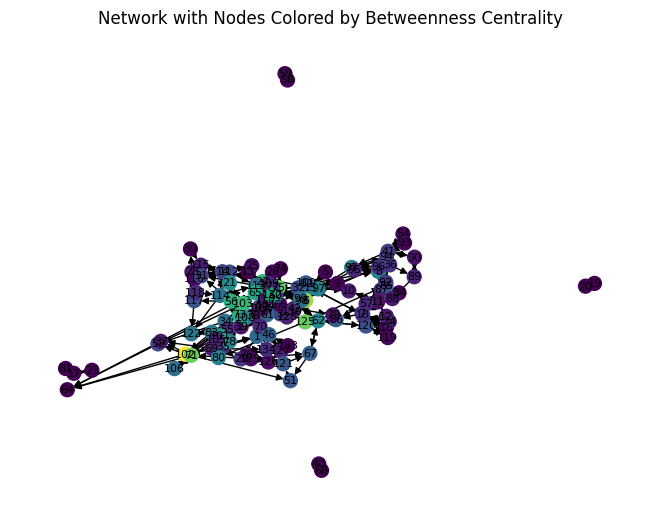

In [34]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_network_with_centrality(graph, centrality_values, title, colormap=plt.cm.plasma):
    """
    Visualize a network with nodes colored by centrality.

    Parameters:
    - graph: NetworkX graph
    - centrality_values: Dictionary of centrality values for each node
    - title: Title of the plot
    - colormap: Matplotlib colormap for node colors
    """
    # Add centrality values to nodes
    nx.set_node_attributes(graph, centrality_values, 'centrality')

    # Extract node positions
    pos = nx.spring_layout(graph)

    # Draw the network with nodes colored by centrality using a specified colormap
    nx.draw(graph, pos, node_color=list(centrality_values.values()), cmap=colormap,
            node_size=100, with_labels=True, font_size=8)

    plt.title(title)
    plt.show()

# Visualize the network with nodes colored by betweenness centrality using a perceptually uniform colormap
visualize_network_with_centrality(G_ferry_venice, betweenness_centrality_ferry, 'Network with Nodes Colored by Betweenness Centrality', colormap=plt.cm.viridis)


In [105]:
#edge betweenness centrality
#equation 21 
edge_betweenness_centrality = nx.edge_betweenness_centrality(G_venice)

# Create dataframes for top 10 edges for edge betweenness centrality with additional information
def create_edge_dataframe(centrality_measure):
    edges_info = [{'from_stop': edge[0], 'to_stop': edge[1],
                   'betweenness_centrality': centrality_measure[edge]}
                  for edge in sorted(centrality_measure, key=centrality_measure.get, reverse=True)[:10]]
    return pd.DataFrame(edges_info)

# Create dataframe for edge betweenness centrality
f_edge_betweenness = create_edge_dataframe(edge_betweenness_centrality)

# Display the dataframe
print("\nTop 10 edges by betweenness centrality:")
print(f_edge_betweenness)


Top 10 edges by betweenness centrality:
   from_stop  to_stop  betweenness_centrality
0        324      540                0.123426
1        470     1300                0.098660
2       1804     1809                0.088665
3        835      834                0.087373
4        834      829                0.087020
5        809      863                0.086029
6       1784     1792                0.084517
7        551     1786                0.083654
8        811      552                0.082963
9       1248     1246                0.081477


In [106]:
#equation13 

shortest_paths = dict(nx.all_pairs_shortest_path_length(G_venice))

# Calculate efficiency
N = len(G_venice.nodes)
efficiency_sum = 0

for i in G_venice.nodes:
    for j in G_venice.nodes:
        if i != j and j in shortest_paths[i]:
            dij = shortest_paths[i][j]
            efficiency_sum += 1 / dij

# Calculate efficiency
efficiency = efficiency_sum / (N * (N - 1))

print("Efficiency of ferry network:", efficiency)

Efficiency of ferry network: 0.03774065987128719


In [107]:
def geodesic_vulnerability(G, v):
    # Calculate the shortest paths for all nodes
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Calculate the shortest paths when bus v is failed
    failed_shortest_paths = dict(nx.single_source_shortest_path_length(G, v))
    
    # Calculate the numerator and denominator for geodesic vulnerability
    numerator_sum = 0
    denominator_sum = 0
    
    for i in G.nodes:
        for j in G.nodes:
            if i != j and j in all_shortest_paths[i]:
                dij = all_shortest_paths[i][j]
                
                # Check if the path exists in failed_shortest_paths
                dvij = failed_shortest_paths[j] if j in failed_shortest_paths else float('inf')
                
                # Check for both infinity and zero distances
                if dij != 0 and dvij != 0 and dvij != float('inf'):
                    numerator_sum += 1 / dvij
                    denominator_sum += 1 / dij
    
    # Calculate geodesic vulnerability and normalize to [0, 1]
    geodesic_vulnerability = max(1 - (numerator_sum / denominator_sum), 0)
    
    print(f"Numerator Sum: {numerator_sum}")
    print(f"Denominator Sum: {denominator_sum}")
    print(f"Geodesic Vulnerability: {geodesic_vulnerability}")
    
    return geodesic_vulnerability

# Example: Calculate geodesic vulnerability for ferry 'v' (replace 'your_bus_id' with the actual bus ID)
your_ferry_id = 135
if your_ferry_id in G_venice.nodes:
    ferry_vulnerability = geodesic_vulnerability(G_venice, your_ferry_id)
    print(f"Geodesic vulnerability for ferry {your_ferry_id}: {ferry_vulnerability}")
else:
    print(f"Ferry {your_ferry_id} not found in the graph.")

Numerator Sum: 110876.18533718293
Denominator Sum: 111887.5198278629
Geodesic Vulnerability: 0.009038849839873908
Geodesic vulnerability for ferry 135: 0.009038849839873908


In [117]:
import networkx as nx
import pandas as pd

# Assuming 'venice_ferry_df' is your DataFrame with ferry station data in Venice
venice_ferry_df = venice_final[venice_final['FERRY'] == 1]  # Replace 'venice_final' with the actual variable name

# Create a directed graph for the ferry network in Venice using networkx
G_venice_ferry = nx.DiGraph()

# Add nodes and edges to the graph for the ferry network in Venice
for index, row in venice_ferry_df.iterrows():
    from_stop = row['from_stop_I']
    to_stop = row['to_stop_I']
    G_venice_ferry.add_edge(from_stop, to_stop)

# Function to calculate geodesic vulnerability for each node
def geodesic_vulnerability(G, v):
    # Calculate the shortest paths for all nodes
    all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))
    
    # Calculate the shortest paths when node v is failed
    failed_shortest_paths = dict(nx.single_source_shortest_path_length(G, v))
    
    # Calculate the numerator and denominator for geodesic vulnerability
    numerator_sum = 0
    denominator_sum = 0
    
    for i in G.nodes:
        for j in G.nodes:
            if i != j and j in all_shortest_paths[i]:
                dij = all_shortest_paths[i][j]
                
                # Check if the path exists in failed_shortest_paths
                dvij = failed_shortest_paths[j] if j in failed_shortest_paths else float('inf')
                
                # Check for both infinity and zero distances
                if dij != 0 and dvij != 0 and dvij != float('inf'):
                    numerator_sum += 1 / dvij
                    denominator_sum += 1 / dij
    
    # Check if denominator_sum is zero before performing the division
    if denominator_sum == 0:
        return 0
    
    # Calculate geodesic vulnerability and normalize to [0, 1]
    geodesic_vulnerability = max(1 - (numerator_sum / denominator_sum), 0)
    
    return geodesic_vulnerability

# Calculate geodesic vulnerability for each node in the ferry network in Venice
venice_ferry_vulnerabilities = {}
for node in G_venice_ferry.nodes:
    vulnerability = geodesic_vulnerability(G_venice_ferry, node)
    venice_ferry_vulnerabilities[node] = vulnerability

# Create DataFrame for ferry station vulnerabilities with additional information
df_venice_ferry_station_vulnerabilities = pd.DataFrame(list(venice_ferry_vulnerabilities.items()), columns=['id', 'Geodesic_Vulnerability'])
df_venice_ferry_station_vulnerabilities = pd.merge(df_venice_ferry_station_vulnerabilities, venice_ferry_df[['stop_I', 'name', 'lat_ferry', 'lon_ferry']], left_on='id', right_on='stop_I', how='left')
df_venice_ferry_station_vulnerabilities = df_venice_ferry_station_vulnerabilities[['id', 'name', 'lat_ferry', 'lon_ferry', 'Geodesic_Vulnerability']]

# Display the top 10 nodes by geodesic vulnerability with additional information
top_nodes_venice_ferry = df_venice_ferry_station_vulnerabilities.nlargest(10, 'Geodesic_Vulnerability')
print("Top 10 ferry stations in Venice by geodesic vulnerability:")
print(top_nodes_venice_ferry)

Top 10 ferry stations in Venice by geodesic vulnerability:
     id                       name  lat_ferry  lon_ferry  \
49    7               Ferrovia "C"  45.438816  12.319038   
197  54                 Rialto "A"  45.439453  12.335298   
230  84     P.le Roma (Parisi) "D"  45.439873  12.320880   
185  93                 Rialto "B"  45.436810  12.333188   
194  51  Lido (S.M.E.) "C" dir. P.  45.447639  12.424682   
164  89                   San Stae  45.442444  12.328820   
165  89                   San Stae  45.440563  12.333899   
147  72  S. Zaccaria (Danieli) "E"  45.432186  12.337525   
183  90                  Ca' D'Oro  45.439453  12.335298   
184  90                  Ca' D'Oro  45.441746  12.330798   

     Geodesic_Vulnerability  
49                 0.294909  
197                0.294606  
230                0.288222  
185                0.268646  
194                0.238776  
164                0.237312  
165                0.237312  
147                0.232276  
183       